# Problem Set 5 
### Tyler Amos
### MACSS 30100
#### 19 February 2018

In [77]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.metrics import classification_report, mean_squared_error
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
sb.set_style('whitegrid')

coolindex_link = 'https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS5/data/CoolIndex.txt'
strongdrink_link = 'https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS5/data/strongdrink.txt'
cool_index = pd.read_csv(coolindex_link, header=None, names = ['age','coolness'])
strong_drink = pd.read_csv(strongdrink_link)

# 1. a)

In [78]:

y_var = ['cultivar']
x_var = ['alco', 'malic', 'tot_phen', 'color_int']

x_poly_strong_drink = strong_drink[x_var].copy()
x_poly_strong_drink['constant'] = 1 # Add constant
y_poly_strong_drink = np.ravel(strong_drink[y_var])

x_train, x_test, y_train, y_test = train_test_split(x_poly_strong_drink, y_poly_strong_drink, test_size = 0.25, random_state=20)
multi_log = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
multi_log.fit(x_train, y_train)
y_pred = multi_log.predict(x_test)

print("\nCOEFFICIENTS AND INTERCEPTS")
print("INTERCEPTS")
print(multi_log.intercept_)
print("\nCOEFFICIENTS")
print(multi_log.coef_)
print("\nCLASSIFICATION REPORT")
class_report = classification_report(y_test, y_pred)
print(class_report)
print("ERROR RATES")
print("Cultivar 1: ", 1-.87)
print("Cultivar 2: ", 1-1)
print("Cultivar 3: ", 1-1)


COEFFICIENTS AND INTERCEPTS
INTERCEPTS
[-24.0108148  22.8025761   1.2082387]

COEFFICIENTS
[[ 1.70038994e+00 -2.65604001e-01  1.22389318e+00  2.27585993e-02
  -8.45998037e-06]
 [-1.46805313e+00 -3.33053748e-01  6.64013944e-01 -9.22712974e-01
  -1.76923783e-05]
 [-2.32336811e-01  5.98657749e-01 -1.88790712e+00  8.99954375e-01
   2.61523587e-05]]

CLASSIFICATION REPORT
             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

ERROR RATES
Cultivar 1:  0.13
Cultivar 2:  0
Cultivar 3:  0


The model is best at predicting Cultivar 3. We can say that Cultivars 2 and 3 are equally well identified (precision), but some Cultivar 2 cases are incorrectly labelled as another, presumably Cultivar 1. 


In [79]:
strong_drink.groupby(y_var).size()

cultivar
1    59
2    71
3    46
dtype: int64

It is apparent that the best-predicted categories are in fact those with the most values. 

# b) Leave One Out Cross-Validation

In [80]:
# Borrowed from R. Evans notes
xvars = x_poly_strong_drink.values
yvals = y_poly_strong_drink # This is already a Numpy array
N_loo = xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(xvars)
error_vec = np.zeros(N_loo)

results_df = DataFrame()
y_test_list = []
y_pred_list = []
indicator_error = []
for train_index, test_index in loo.split(xvars):
    x_train, x_test = xvars[train_index], xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    multi_log = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
    multi_log.fit(x_train, y_train)
    y_pred = multi_log.predict(x_test)
    y_test_list.append(y_test[0])
    y_pred_list.append(y_pred[0])
    indicator_error.append(1 if y_test[0] == y_pred else 0)
results_df['y_pred'] = y_pred_list
results_df['y_test'] = y_test_list
results_df['error'] = indicator_error
    
print("\nCLASSIFICATION REPORT")
class_report = classification_report(results_df['y_test'], results_df['y_pred'])
print(class_report)

print("ERROR RATES")
print("Cultivar 1: ", 1-.90)
print("Cultivar 2: ", 1-.91)
print("Cultivar 3: ", 1-.96)

print("\nMSE")
print("LOOCV ", results_df['error'].mean())



CLASSIFICATION REPORT
             precision    recall  f1-score   support

          1       0.90      0.93      0.92        59
          2       0.91      0.90      0.91        71
          3       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176

ERROR RATES
Cultivar 1:  0.09999999999999998
Cultivar 2:  0.08999999999999997
Cultivar 3:  0.040000000000000036

MSE
LOOCV  0.9204545454545454


The error rates have decreased relative to part (a). In part (a), the error rates were as high as 0.13. However, with Leave One Out, the error rates are slightly smaller $\approx 0.09$ for all Cultivars. However, we also see higher errors for Cultivars 2 and 3. This seems more plausible than part (a), as the errors are distributed more evenly across the cultivars. 

# c) K-Fold Cross-Validation

In [81]:
from sklearn.model_selection import KFold
k = 4
xvars = x_poly_strong_drink.values
yvals = y_poly_strong_drink # This is already a Numpy array
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(xvars)
MSE_vec_kf = np.zeros(k)

k_ind = int(0)
results_df = DataFrame()
y_test_list = []
y_pred_list = []
indicator_error = []
for train_index, test_index in kf.split(xvars):
    print('k index=', k_ind)
    x_train, x_test = xvars[train_index], xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    multi_log = LogisticRegression(multi_class='multinomial', solver ='newton-cg')
    multi_log.fit(x_train, y_train)
    y_pred = multi_log.predict(x_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1
    
MSE_kf = MSE_vec_kf.mean()
print('\nK-FOLD MSE ', MSE_kf)

k index= 0
MSE for test set 0  is 0.22727272727272727
k index= 1
MSE for test set 1  is 0.11363636363636363
k index= 2
MSE for test set 2  is 0.045454545454545456
k index= 3
MSE for test set 3  is 0.045454545454545456

K-FOLD MSE  0.10795454545454546


These error rates are slightly higher than (a) and (b). 



# 2. Splines and Interpolation

# a)

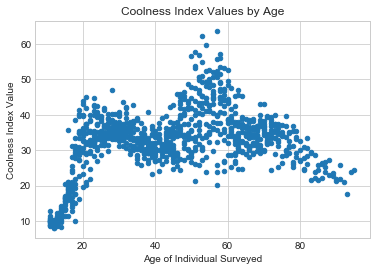

In [82]:
cool_index.plot(kind = 'scatter', x = 'age', y = 'coolness', title = 'Coolness Index Values by Age')
plt.xlabel('Age of Individual Surveyed')
plt.ylabel('Coolness Index Value');

# b) Stepwise Function

In [83]:
cool = cool_index['coolness']
age = cool_index['age']
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age < 95)).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
reg2 = sm.OLS(endog=cool, exog=X_step, missing='drop')
reg2_results = reg2.fit()
print(reg2_results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4280.
Date:                Mon, 19 Feb 2018   Prob (F-statistic):               0.00
Time:                        11:17:25   Log-Likelihood:                -3220.5
No. Observations:                 956   AIC:                             6451.
Df Residuals:                     951   BIC:                             6475.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.566     35.522      0.0

COEFFICIENTS
age_bin1    20.102457
age_bin2    34.475788
age_bin3    37.635105
age_bin4    35.225400
age_bin5    27.348167
dtype: float64


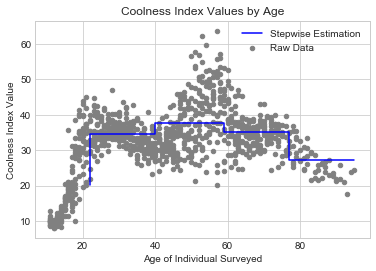

In [84]:
cool_index.plot(kind = 'scatter', x = 'age', y = 'coolness', color = "grey", title = 'Coolness Index Values by Age', label = "Raw Data")
plt.xlabel('Age of Individual Surveyed')
plt.ylabel('Coolness Index Value')
plt.step([22,40, 59, 77, 95], reg2_results.params, color = "blue", label = "Stepwise Estimation")
plt.legend()
print("COEFFICIENTS")
print(reg2_results.params)

In [85]:
print("PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k= 1", reg2_results.params[3])


PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k= 1 35.22540004024275


# c) 

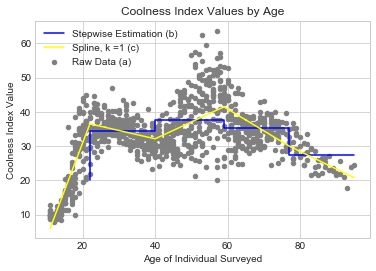

In [86]:
from scipy.interpolate import LSQUnivariateSpline
knots  = [22,40,59,77]
spl = LSQUnivariateSpline(age.values, cool.values, knots, k=1)
cool_index.plot(kind = 'scatter', x = 'age', y = 'coolness', color = "grey", title = 'Coolness Index Values by Age', label = "Raw Data (a)")
plt.xlabel('Age of Individual Surveyed')
plt.ylabel('Coolness Index Value')
plt.step([22,40, 59, 77, 95], reg2_results.params, color = "blue", label = "Stepwise Estimation (b)")
plt.plot(age.values, spl(age.values), color = "yellow", label = "Spline, k =1 (c)")
plt.legend();

In [87]:
print("PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k= 1", spl(73))

PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k= 1 32.536832389143306


# d)

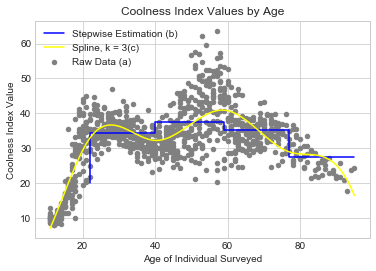

In [88]:
knots  = [22,40,59,77]
spl2 = LSQUnivariateSpline(age.values, cool.values, knots, k=3)
cool_index.plot(kind = 'scatter', x = 'age', y = 'coolness', color = "grey", title = 'Coolness Index Values by Age', label = "Raw Data (a)")
plt.xlabel('Age of Individual Surveyed')
plt.ylabel('Coolness Index Value')
plt.step([22,40, 59, 77, 95], reg2_results.params, color = "blue", label = "Stepwise Estimation (b)")
plt.plot(age.values, spl2(age.values), color = "yellow", label = "Spline, k = 3(c)")
plt.legend();

In [89]:
print("PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k = 3", spl(73))

PREDICTED COOLNESS OF 73-YEAR-OLD, SPLINE WITH k = 3 32.536832389143306
